# 0. Imports

In [2]:
import math
import random
import pickle
import datetime
import inflection

import numpy                as np
import pandas               as pd
import seaborn              as sns
import xgboost              as xgb
import matplotlib.pyplot    as plt

from scipy                  import stats
from boruta                 import BorutaPy
from tabulate               import tabulate
from datetime               import timedelta
from IPython.display        import Image
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from matplotlib.gridspec    import GridSpec
from IPython.core.display   import HTML
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [3]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    return np.sqrt((chi2corr / n) / (min( kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])
                         
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k - 1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0])

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename columns

df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
df1.describe()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1014567.00,693861.00,693861.00,1017209.00,509178.00,509178.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18,5430.09,7.22,2008.69,0.50,23.27,2011.75
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38,7715.32,3.21,5.99,0.50,14.10,1.66
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00,2330.00,8.00,2010.00,1.00,22.00,2012.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


In [13]:
# competition_distance : 
# there are no store near enough to be considered a competition, replacing NaN values with a number big enough to represent this distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month : 
# The store doesn't have a near competitor or it is impossible to know when the competitor store opened
# copying the month of the date column to this one so it seems the comnpetition was there since the beginning
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year : 
# The store doesn't have a near competitor or it is impossible to know when the competitor store opened
# copying the month of the date column to this one so it seems the comnpetition was there since the beginning
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week :
# the store dicided not to participate in this promo, using the week of the column date to fill na
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year :
# the store dicided not to participate in this promo, using the year of the column date to fill na
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1 ['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,promo2,0.00,1.00,1.00,0.50,1.00,0.50,-0.00,-2.00
9,is_promo,0.00,1.00,1.00,0.17,0.00,0.38,1.74,1.03


C:\Users\pma2022\AppData\Local\Temp\ipykernel_900\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

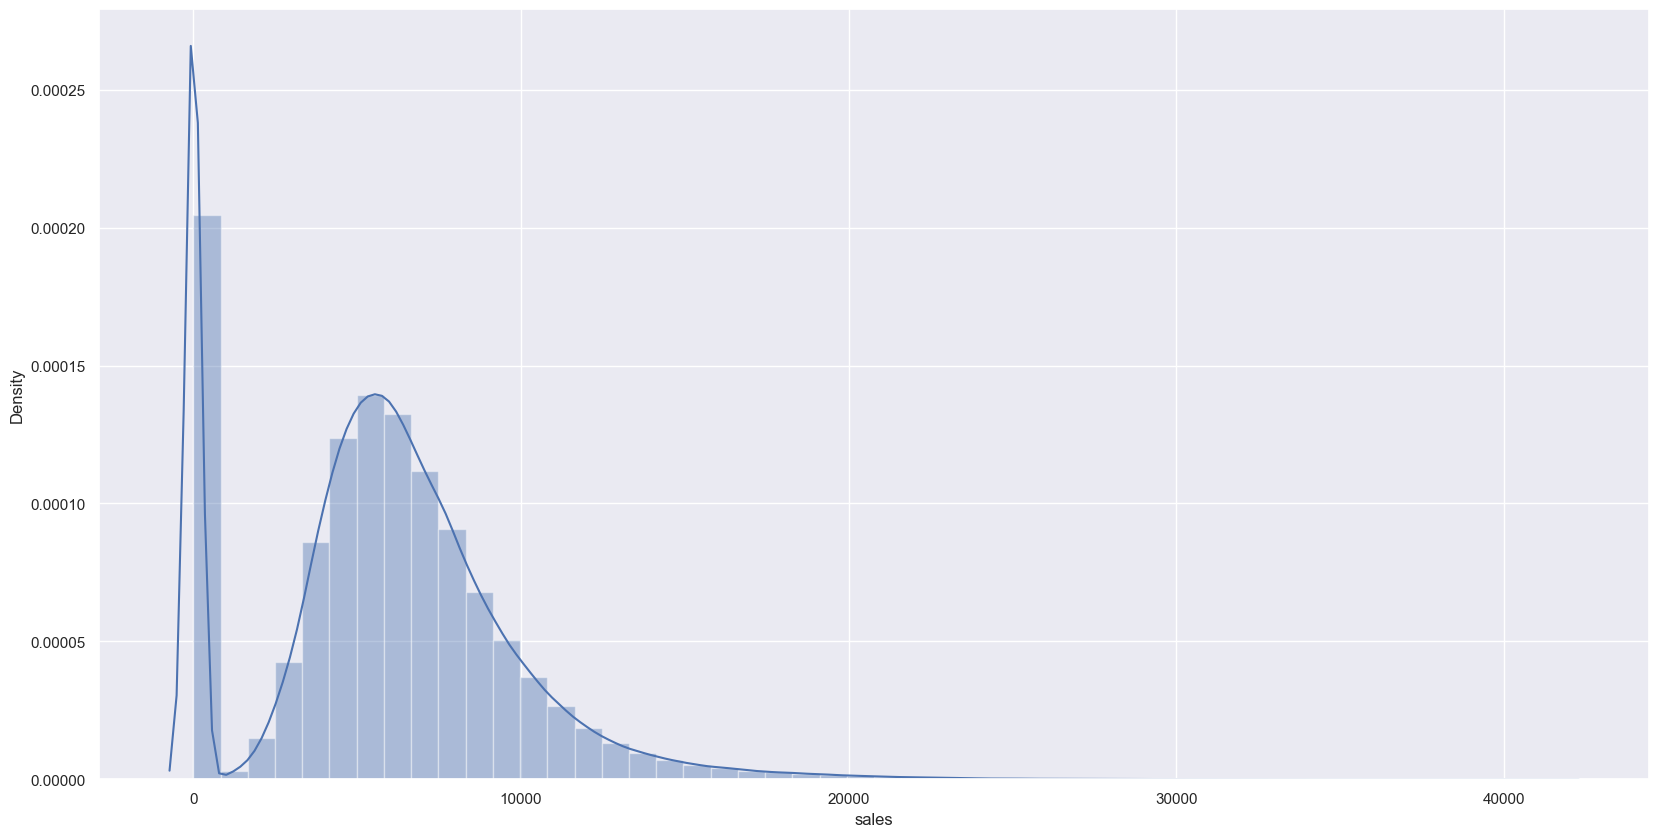

In [19]:
sns.distplot(df1['sales'])

### 1.7.2. Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

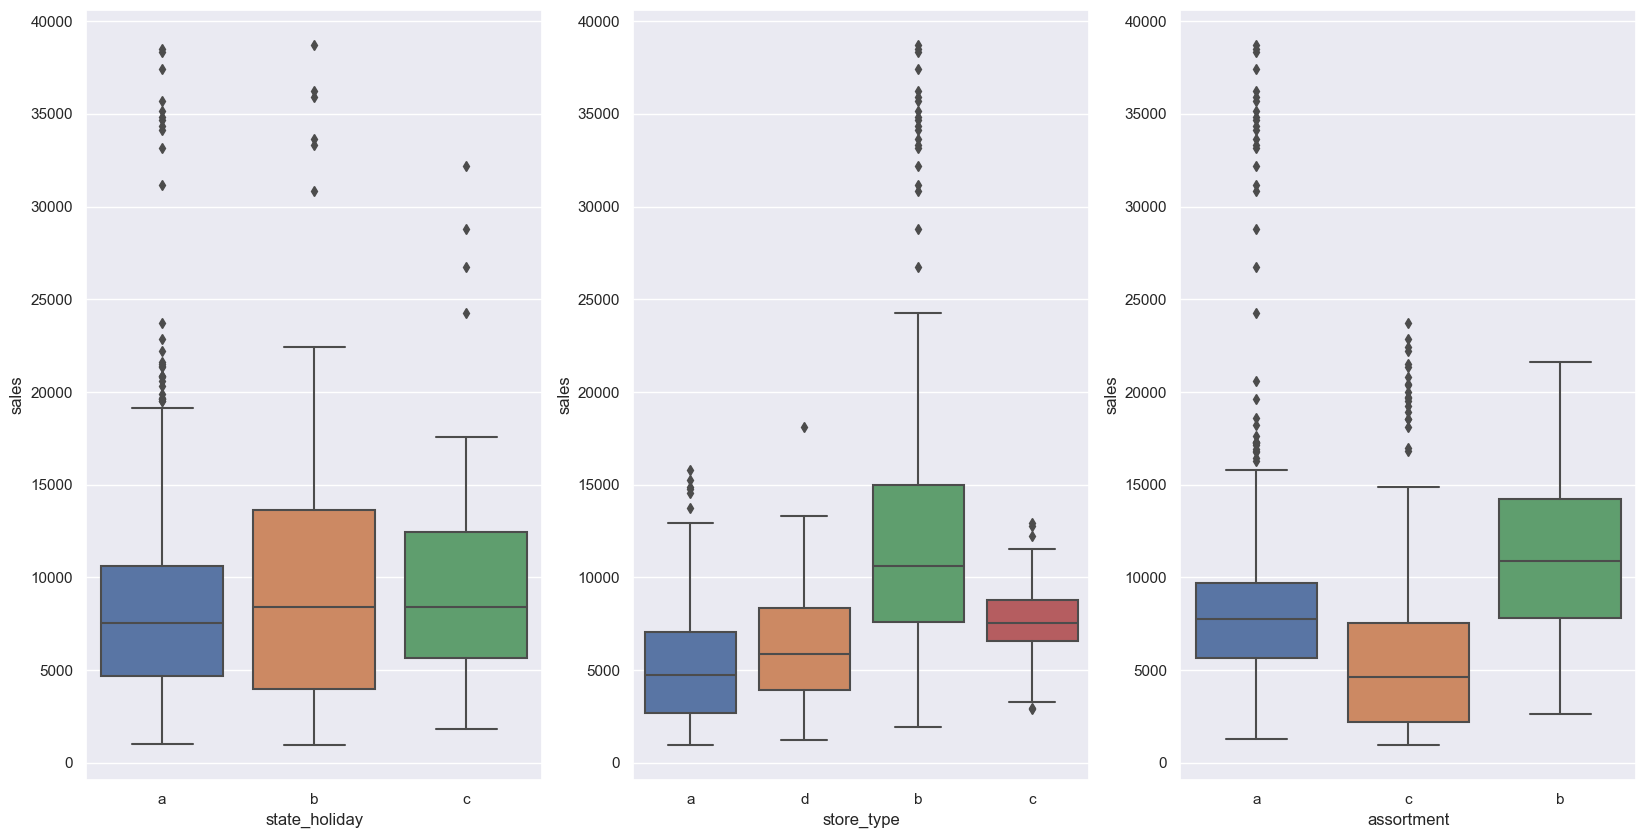

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2. Feature Engineering

In [22]:
df2 = df1.copy()

## 2.1. Hypothesis Mindmap

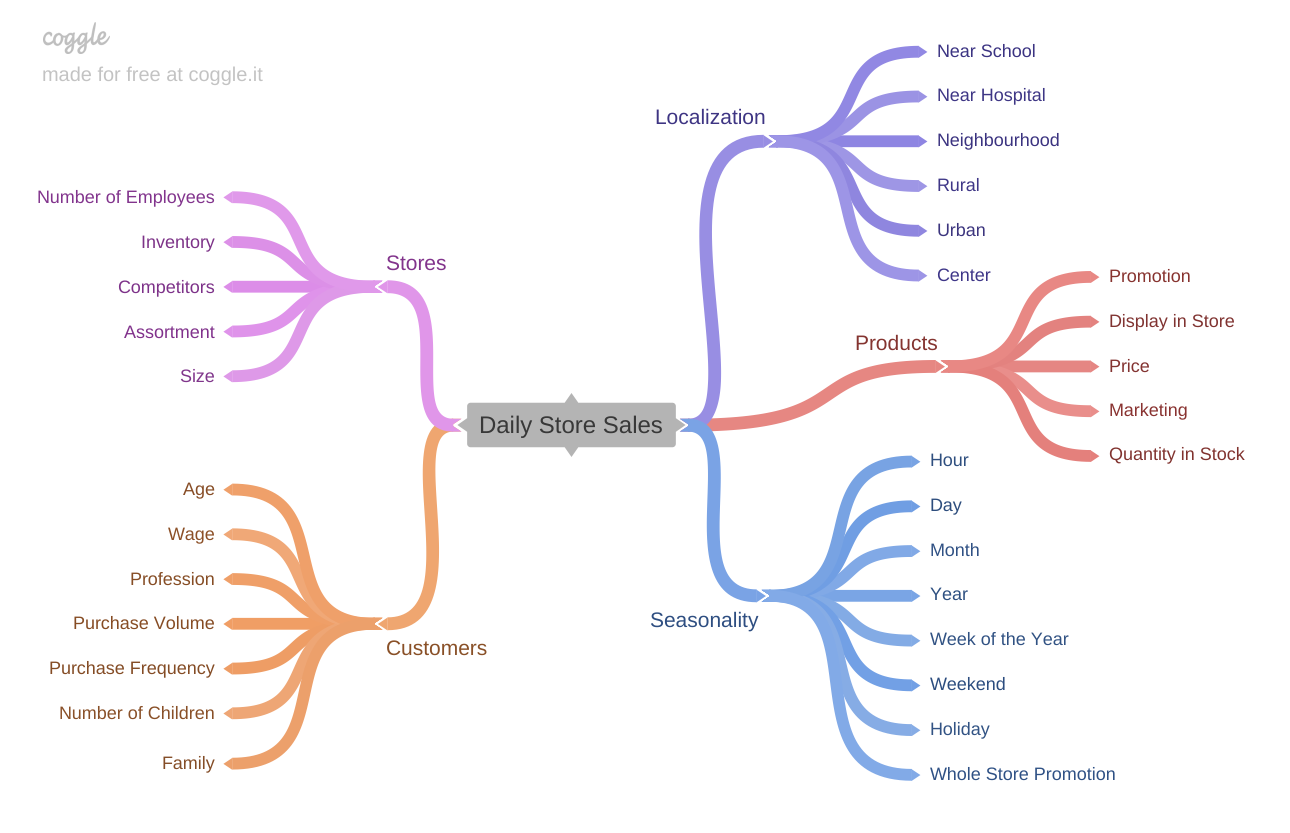

In [23]:
Image('img/mind_map_hypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1 Store Hypothesis

1. Stores with more employees should sell more.

2. Stores with greater inventory capacity should sell more.

3. Larger stores should sell more.

4. Stores with greater assortments should sell more.

5. Stores with closer competitors should sell less.

6. Stores that have a competitor for longer periods of time should sell more.

### 2.2.2 Product Hypothesis

1. Stores that invest more in Marketing should sell more.

2. Stores with more product exposure should sell more.

3. Stores with lower priced products should sell more.

5. Stores with more aggressive promotions (bigger discounts) should sell more.

6. Stores with longer running promotions should sell more.

7. Stores with more promotion days should sell more.

8. Stores with more consecutive promotions should sell more

### 2.2.3 Seasonality Hypothesis

1. Stores open during the Christmas holiday should sell more.

2. Stores should sell more over the years.

3. Stores should sell more in the second half of the year.

4. Stores should sell more after the 10th of each month.

5. Stores should sell less on weekends.

6. Stores should sell less during school holidays.

## 2.3. Final List of Hypothesis

1. Stores with greater assortments should sell more.

2. Stores with closer competitors should sell less.

3. Stores that have a competitor for longer periods of time should sell more.


4. Stores with longer active promotions should sell more.

5. Stores with more promotion days should sell more.

6. Stores with more consecutive promotions should sell more.


7. Stores open during the Christmas holiday should sell more.

8. Stores should sell more over the years.

9. Stores should sell more in the second half of the year.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

## 2.4. Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. Variable Filtering

In [26]:
df3 = df2.copy()

## 3.1. Row Filtering

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Select Columns

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4. EDA (Exploratory Data Analysis)

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

C:\Users\pma2022\AppData\Local\Temp\ipykernel_900\263841694.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=False)


<AxesSubplot:xlabel='sales'>

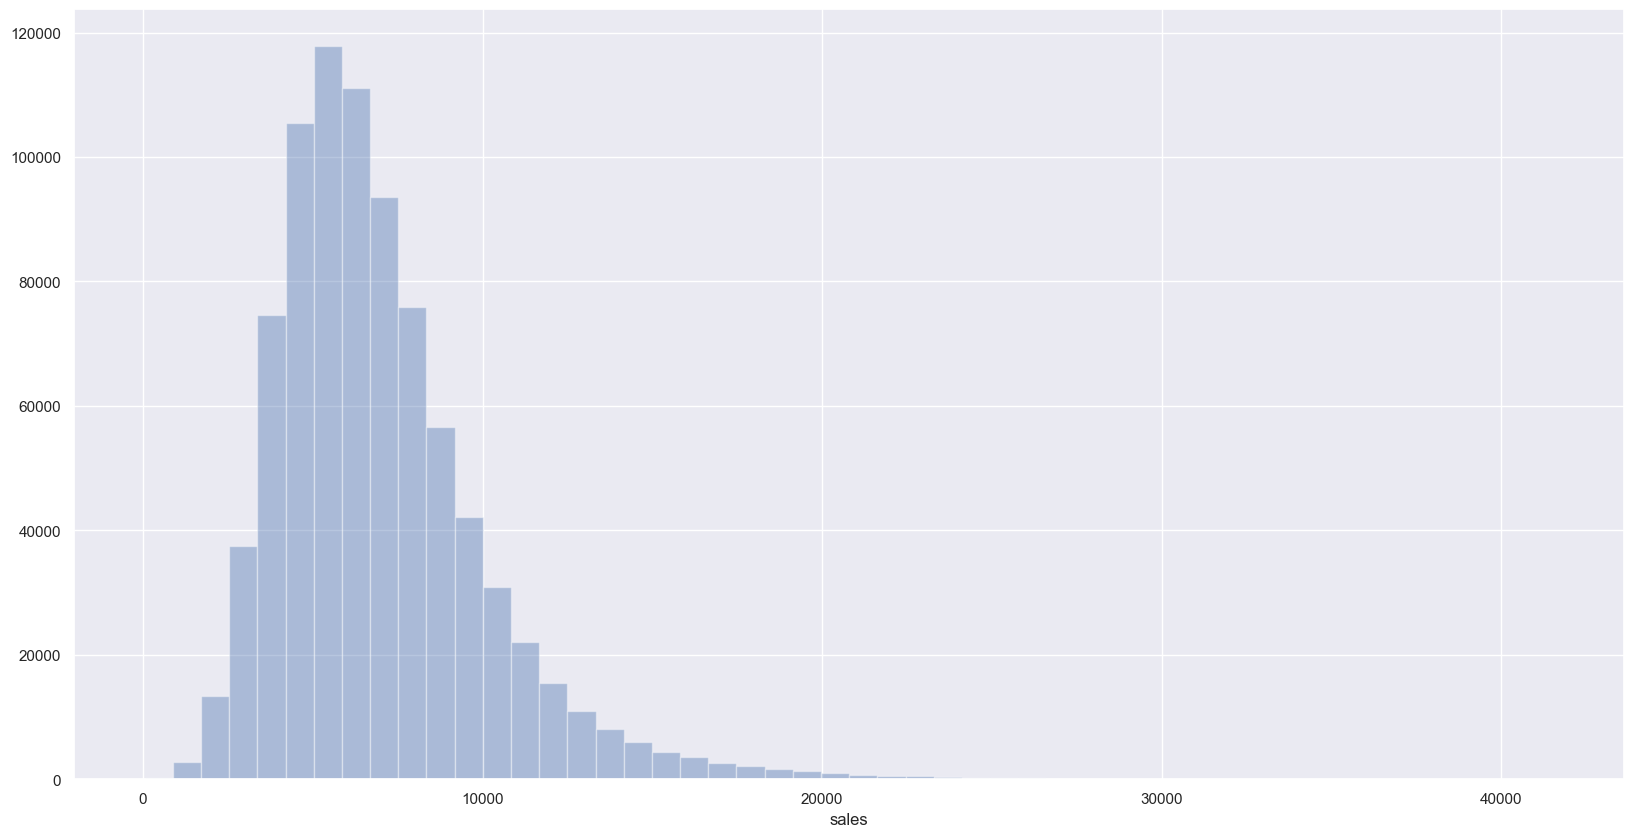

In [30]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

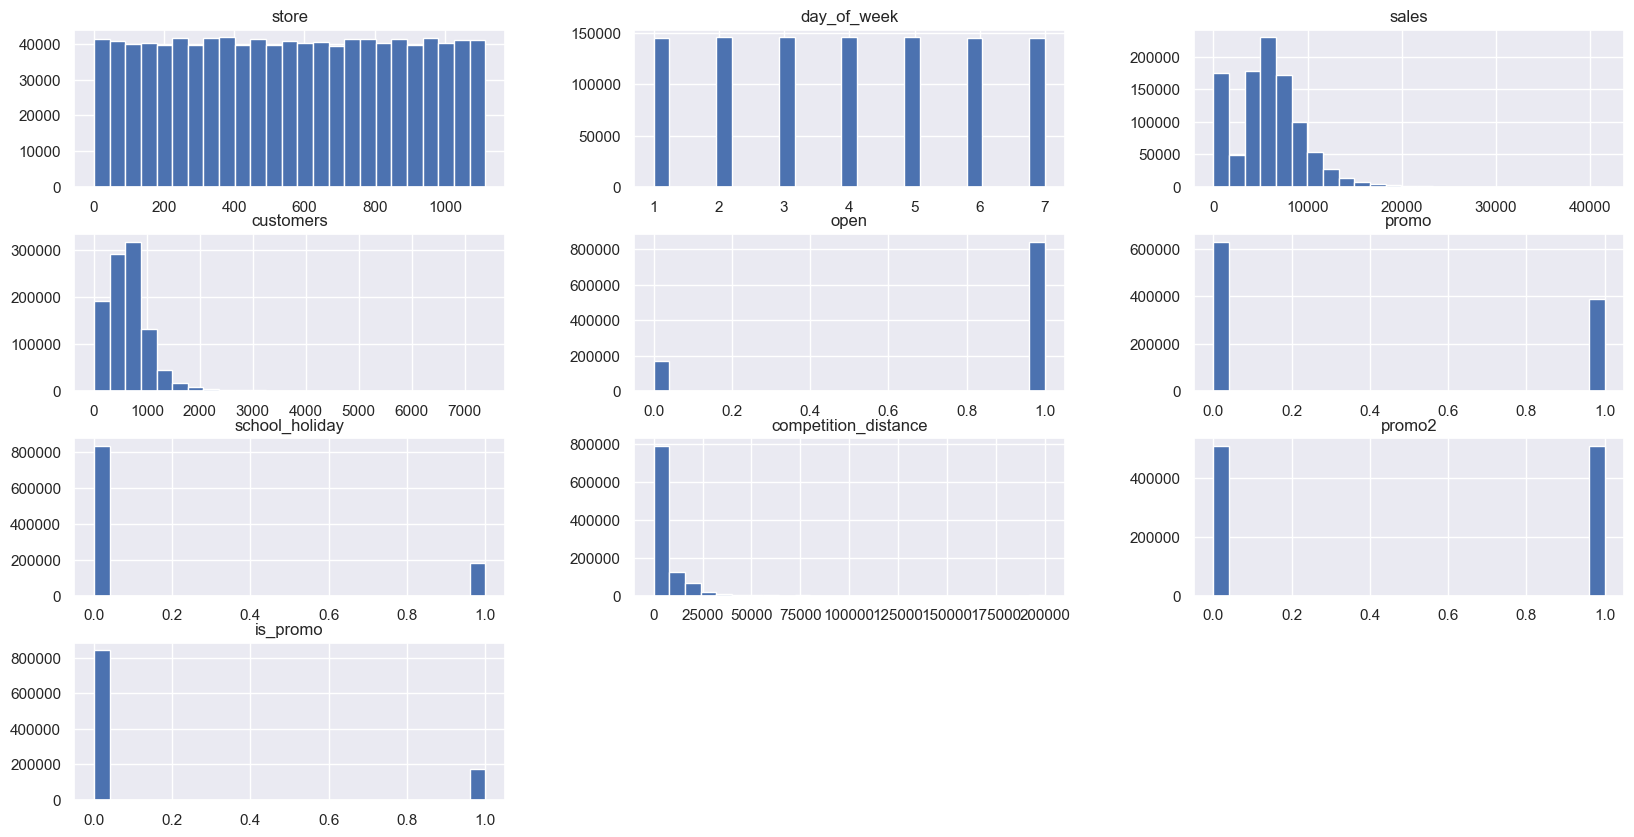

In [31]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

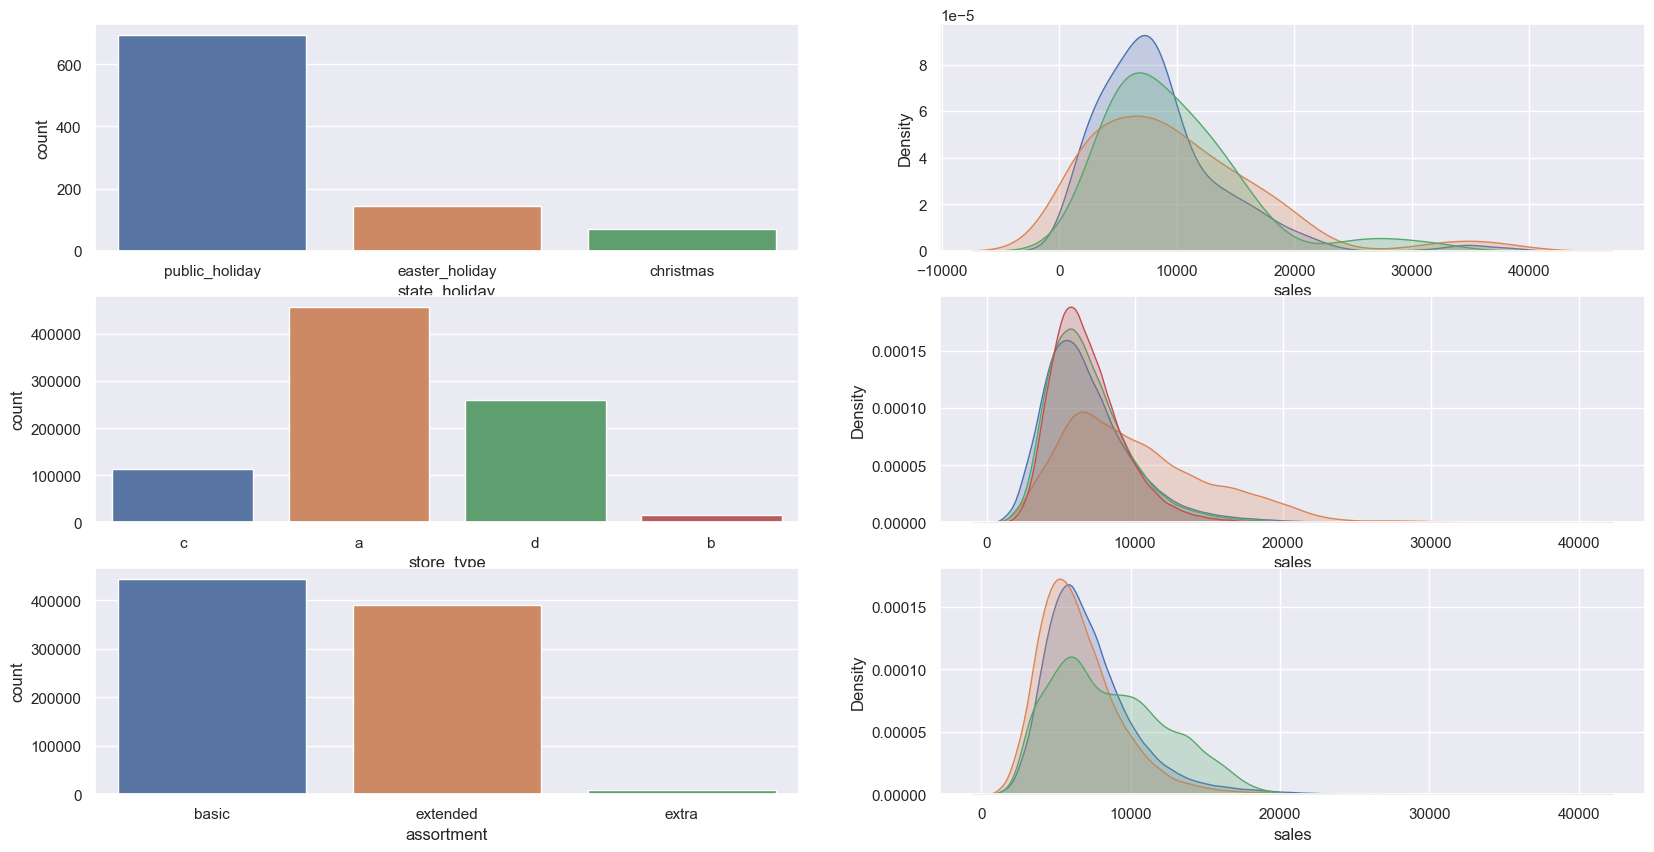

In [32]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 4.2. Bivariate Analysis

### 4.2.1. H1. Stores with greater assortments should sell more. Assuming that the extra assortment is greater tha extended and basic.

True: Stores with greater assortment sell more.

<AxesSubplot:xlabel='year_week'>

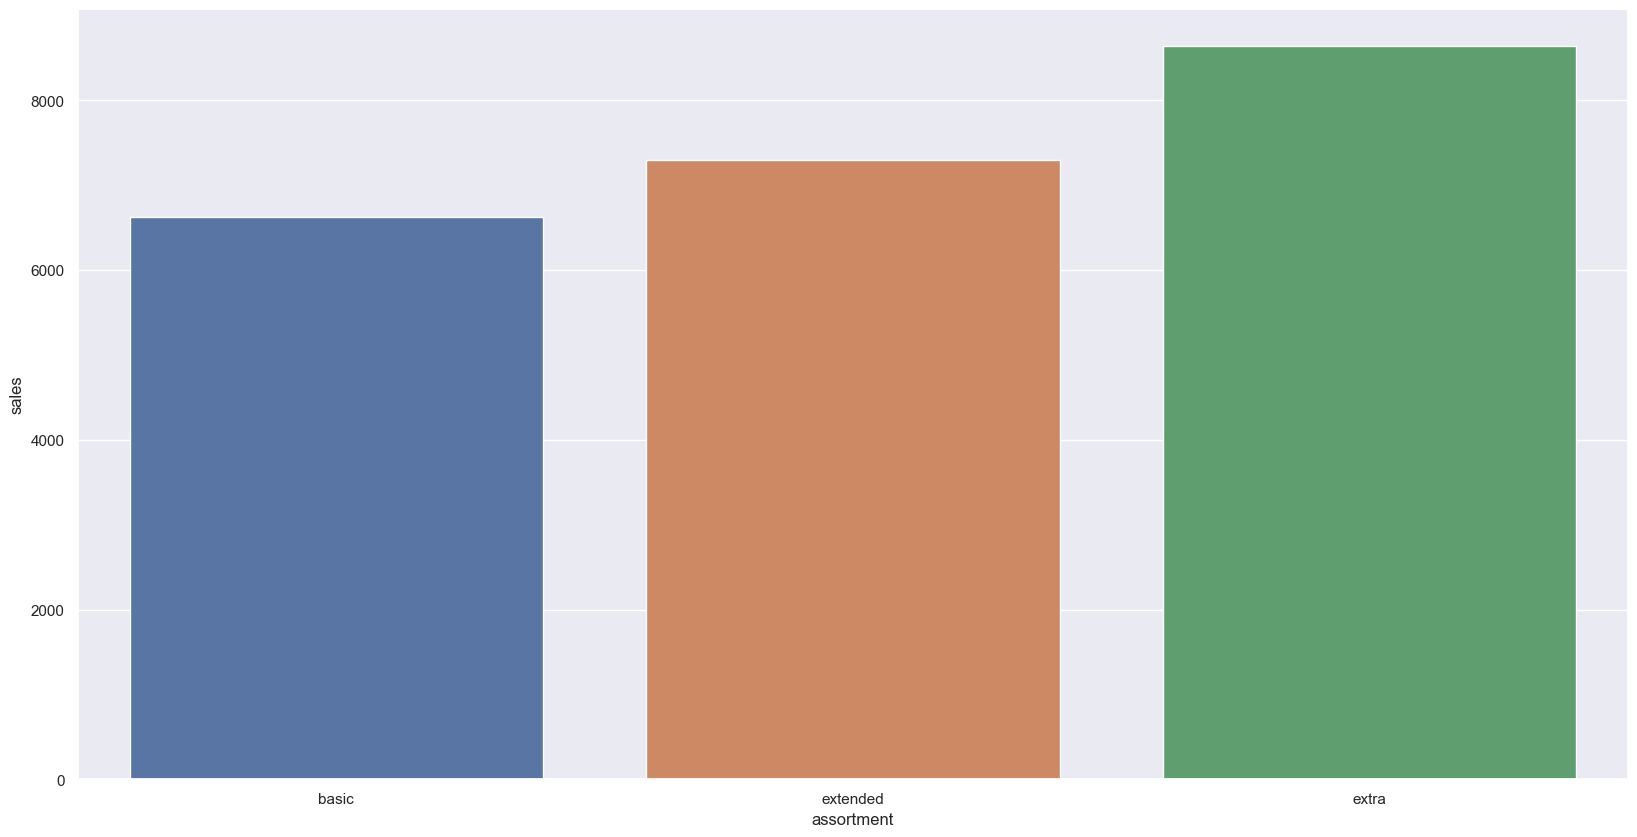

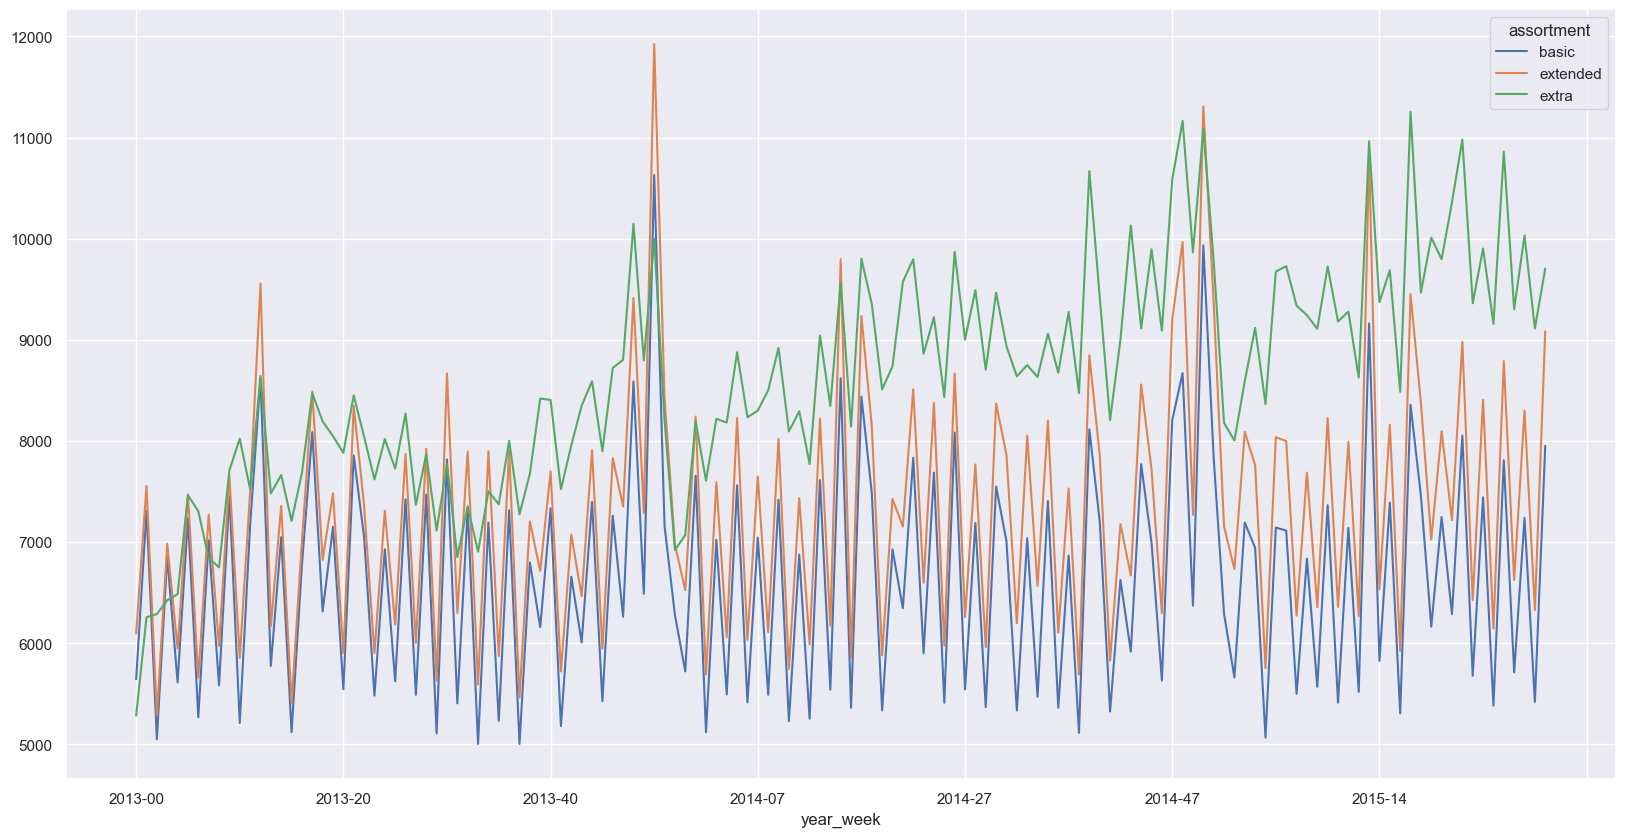

In [33]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

### 4.2.2. H2. Stores with closer competitors should sell less.

False: Stores with closer competitors sells almost the same average amount than the others.

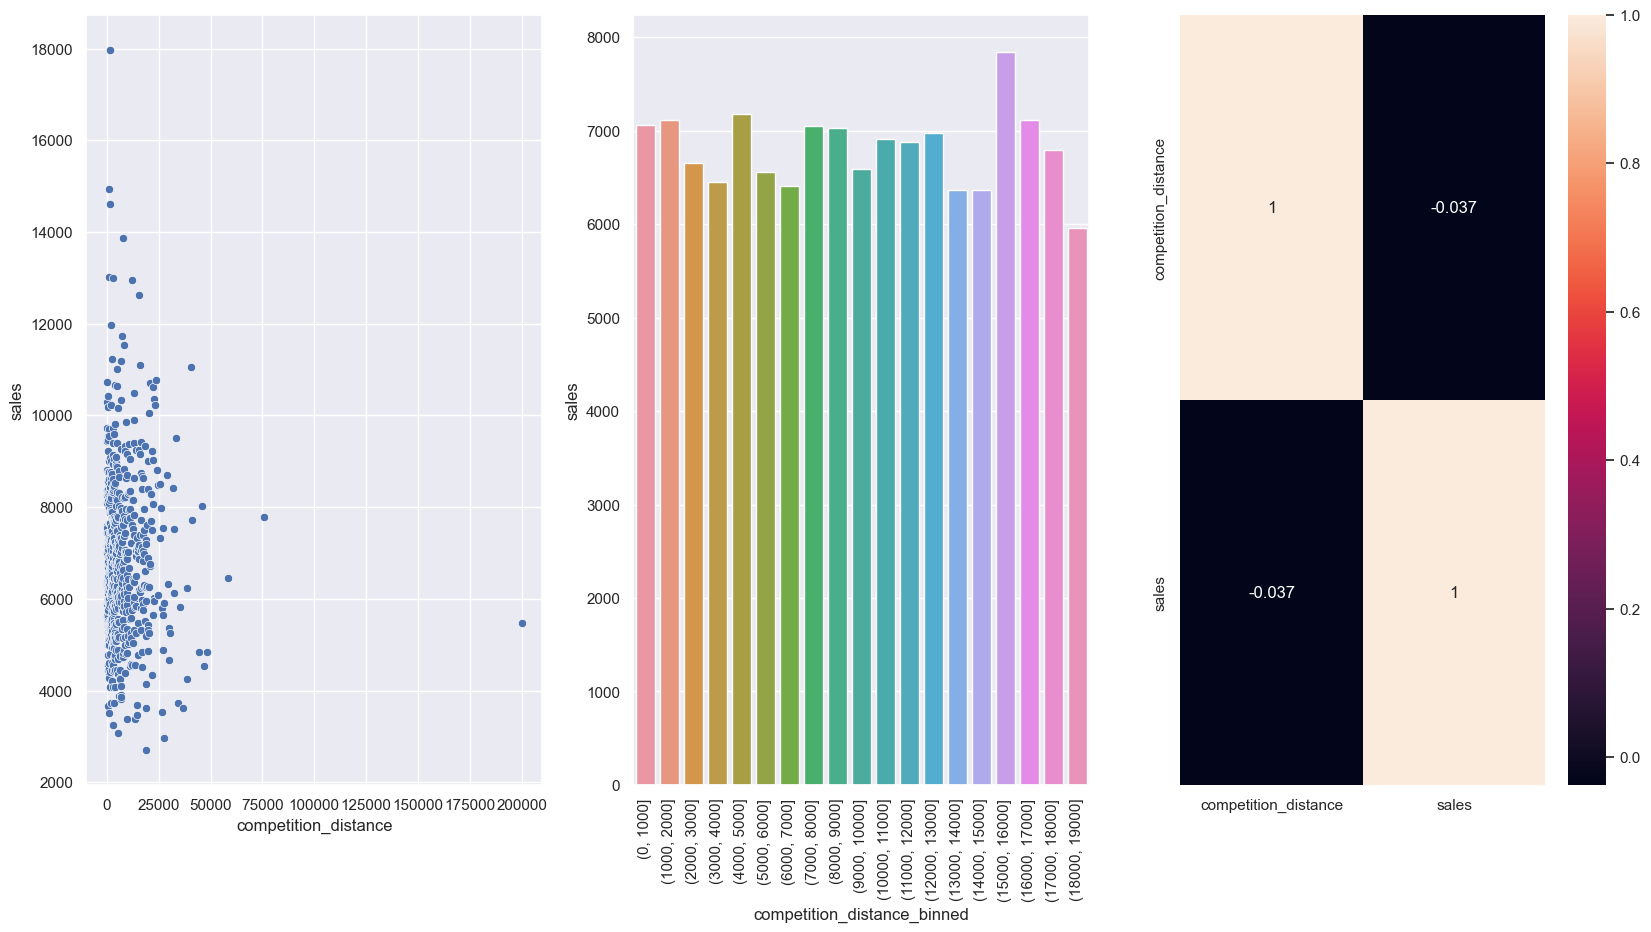

In [34]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.3. H3. Stores that have a competitor for longer periods of time should sell more.
    
False: Stores with competitors for a longer time sell less.

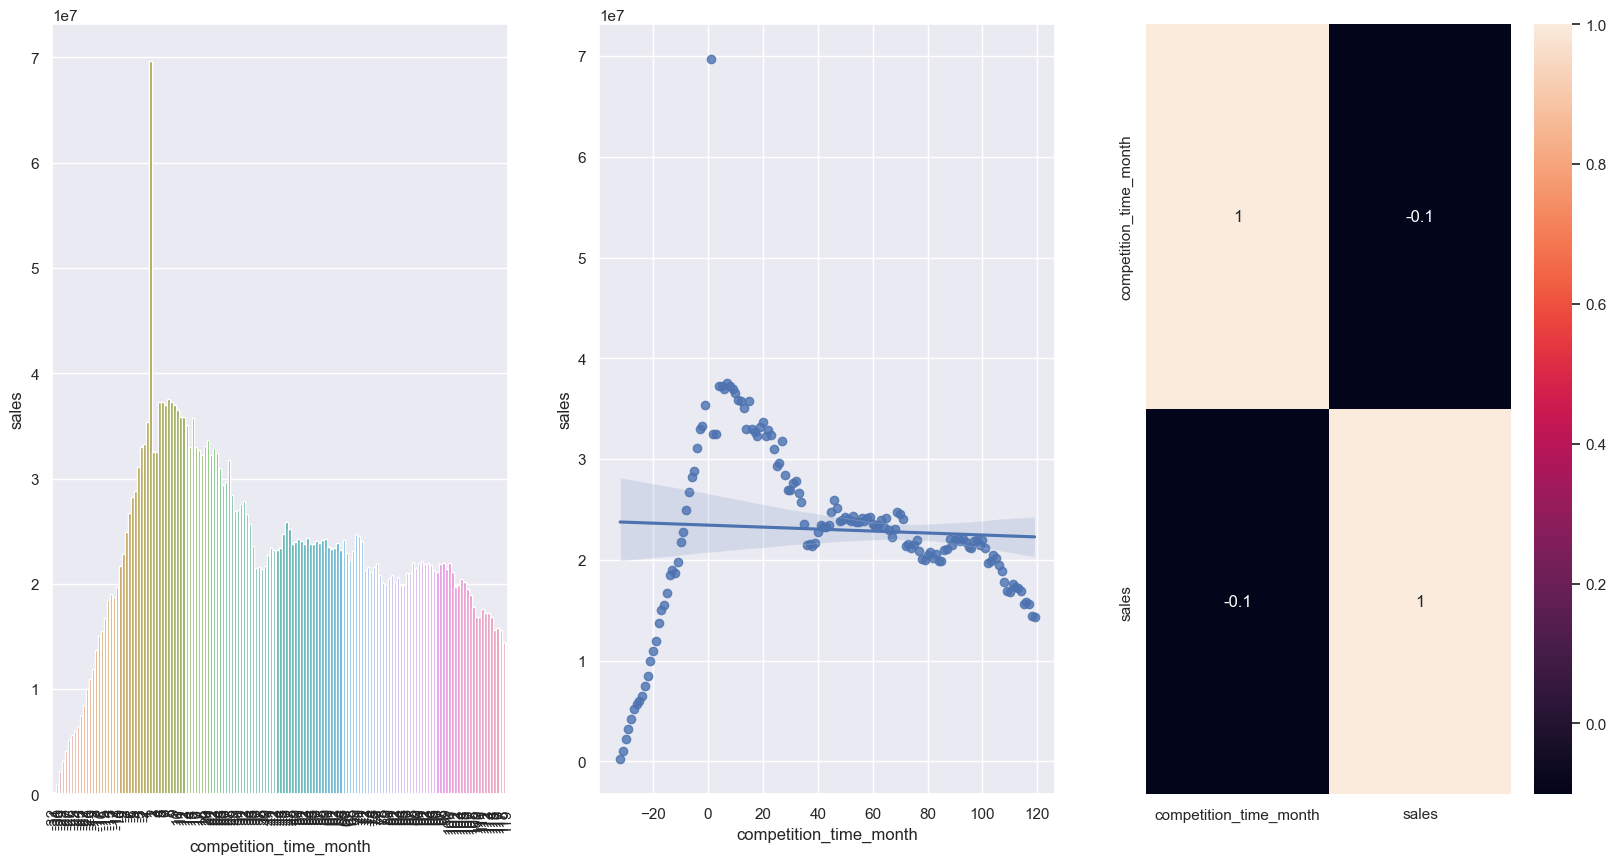

In [35]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.4. H4. Stores with longer active promotions should sell more.

False: Store with longer promotions stop selling more after some time.

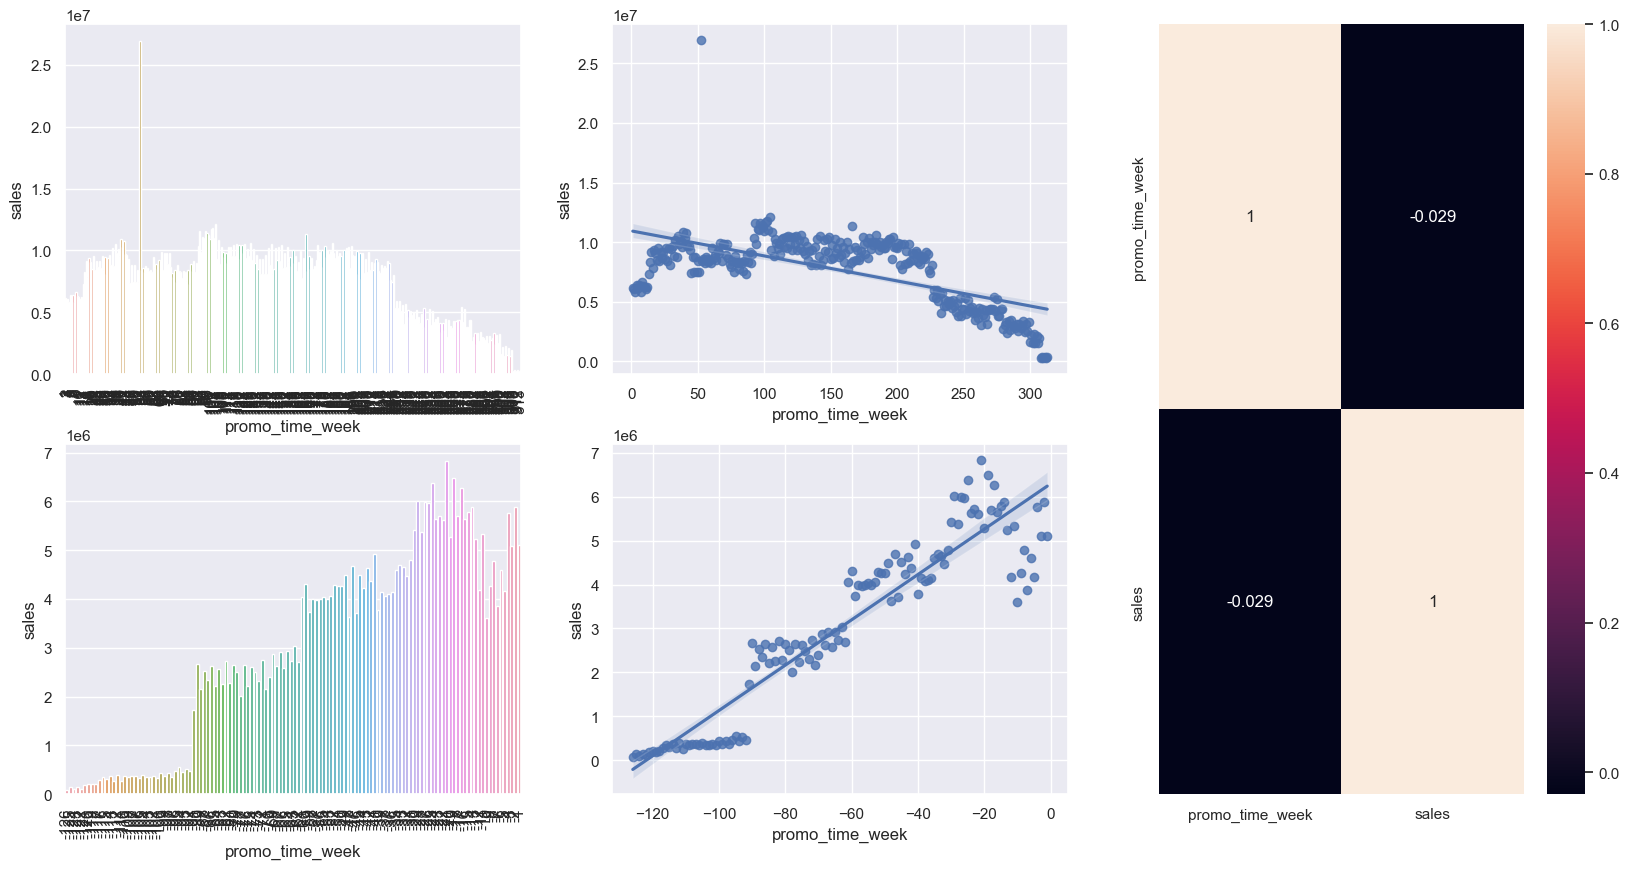

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.5. <s>H5. Stores with more promotion days should sell more.</s> Very Similar to the previous one.

### 4.2.6. H6. Stores with more consecutive promotions should sell more.

False: Stores with more consecutive promotions sell less.

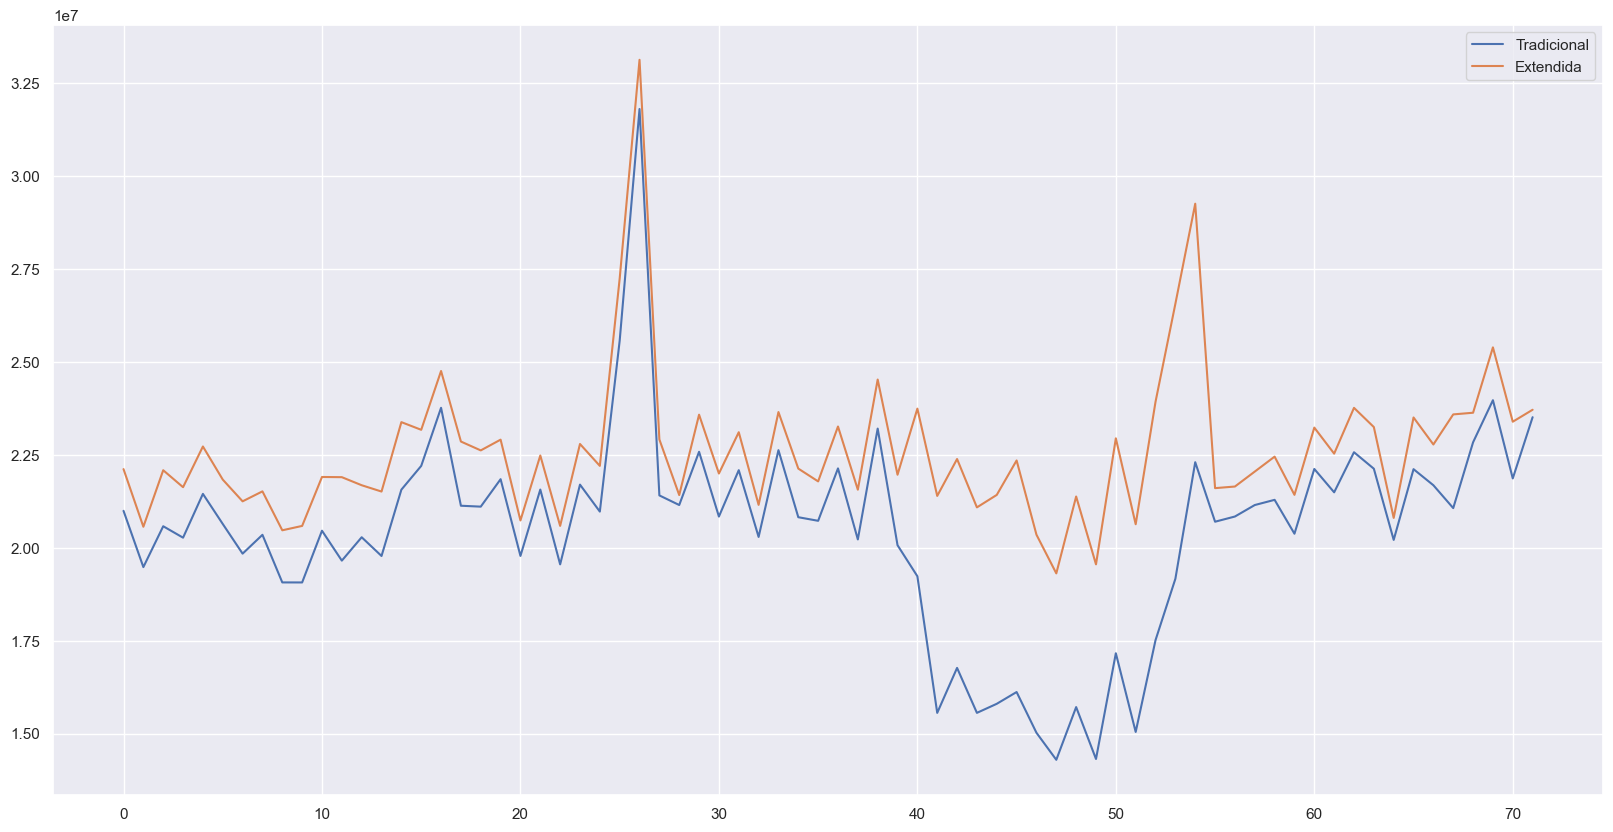

In [37]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional', 'Extendida'])


### 4.2.7. H7. Stores open during the Christmas holiday should sell more.

False: Stores open during Christmas don't sell more.

<AxesSubplot:xlabel='year', ylabel='sales'>

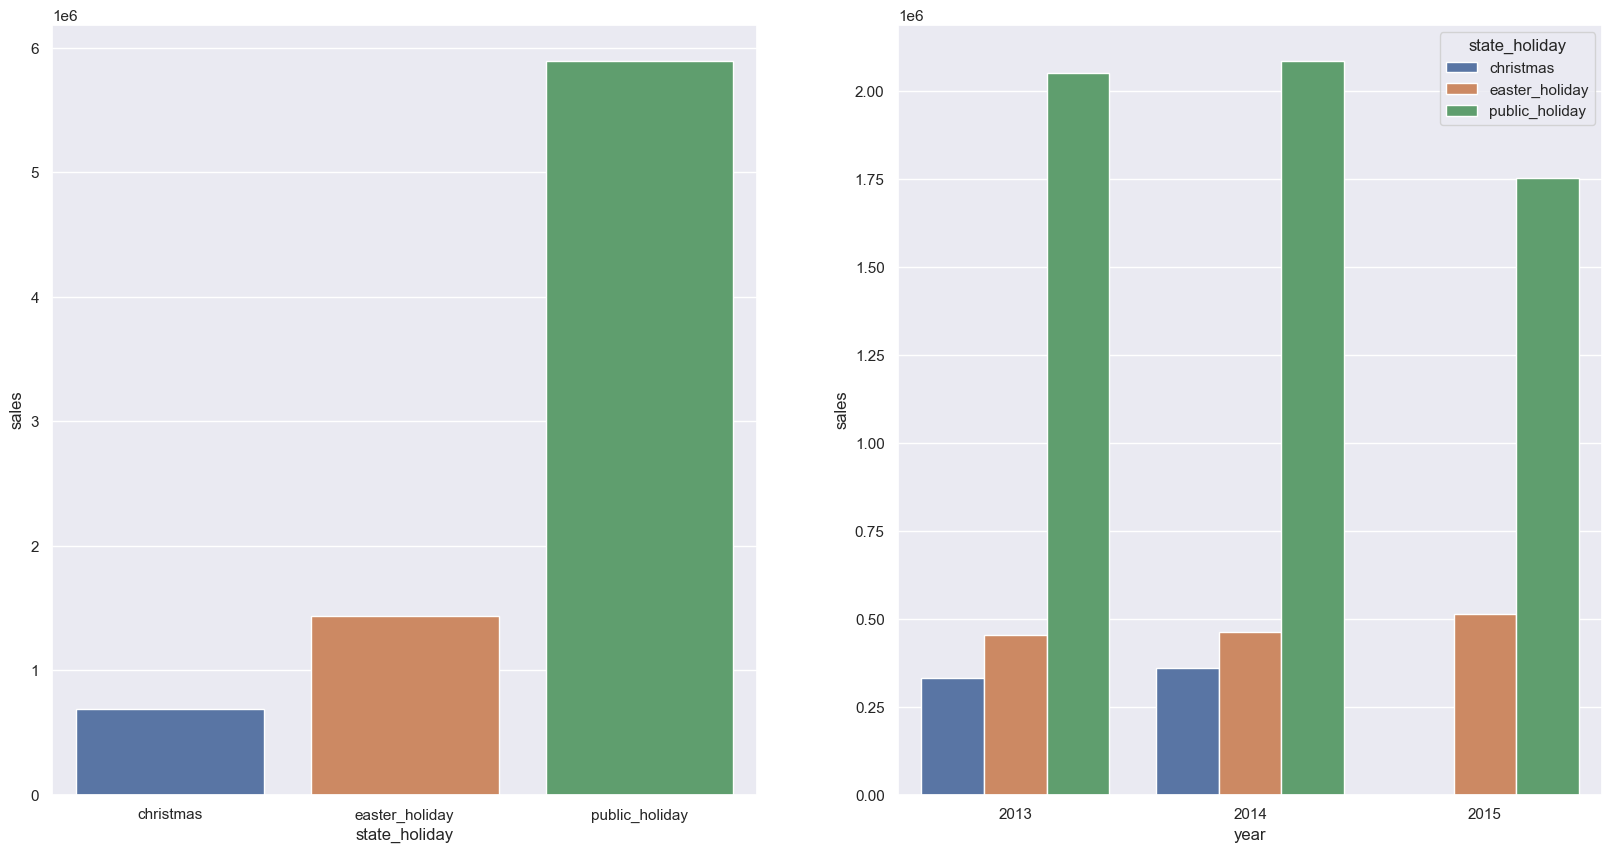

In [38]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### 4.2.8. H8. Stores should sell more over the years.

False: Stores sell less over the years.

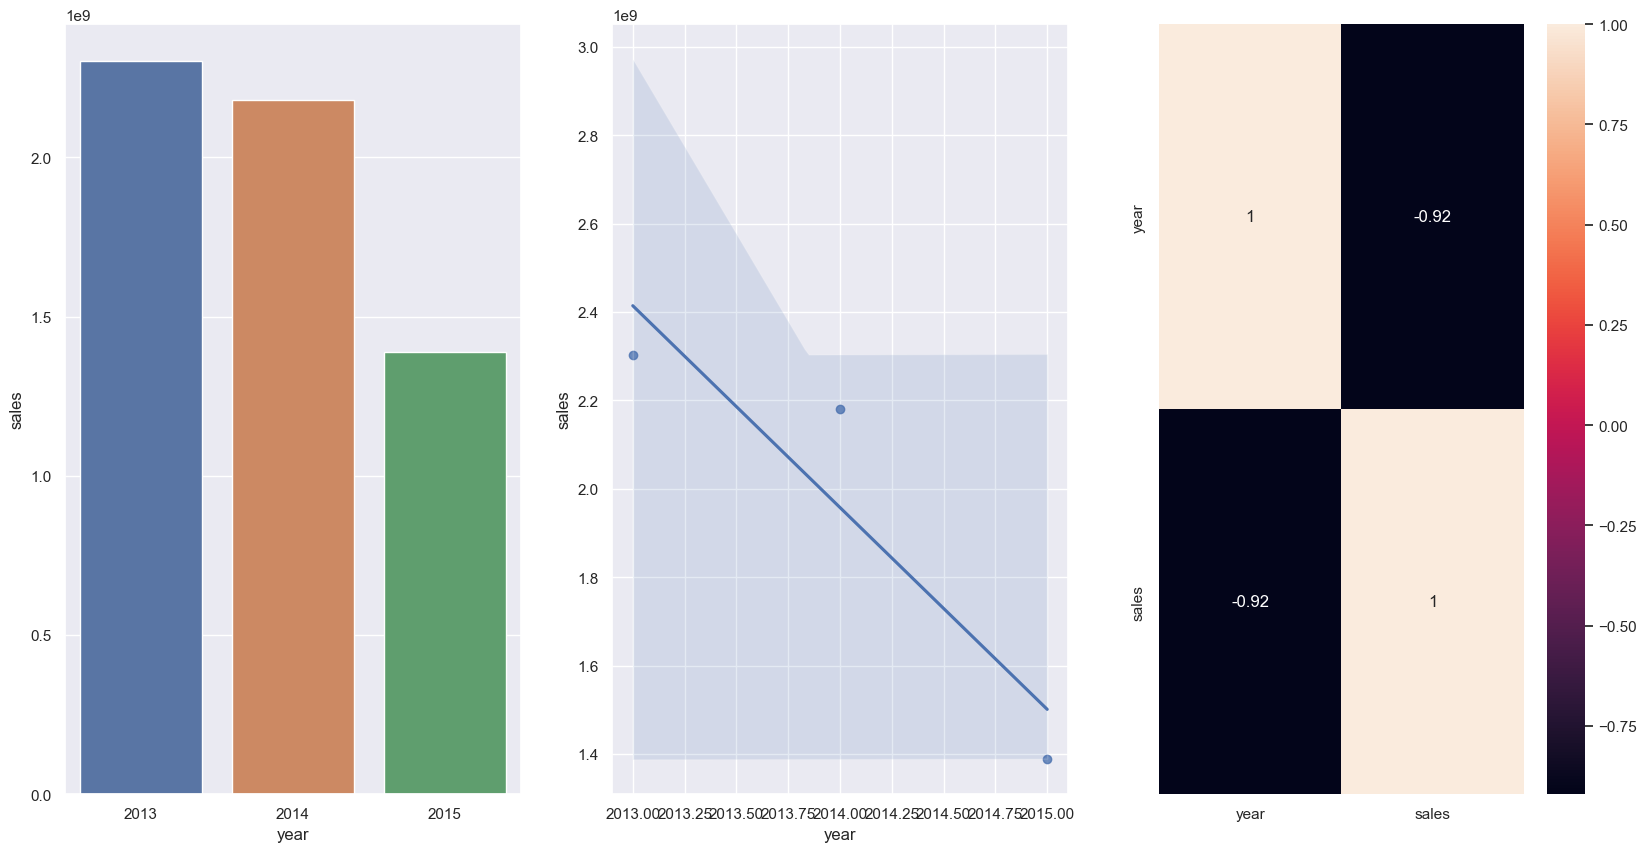

In [39]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.9. H9. Stores should sell more in the second half of the year.

True: The stores sell more in the second half of the year.

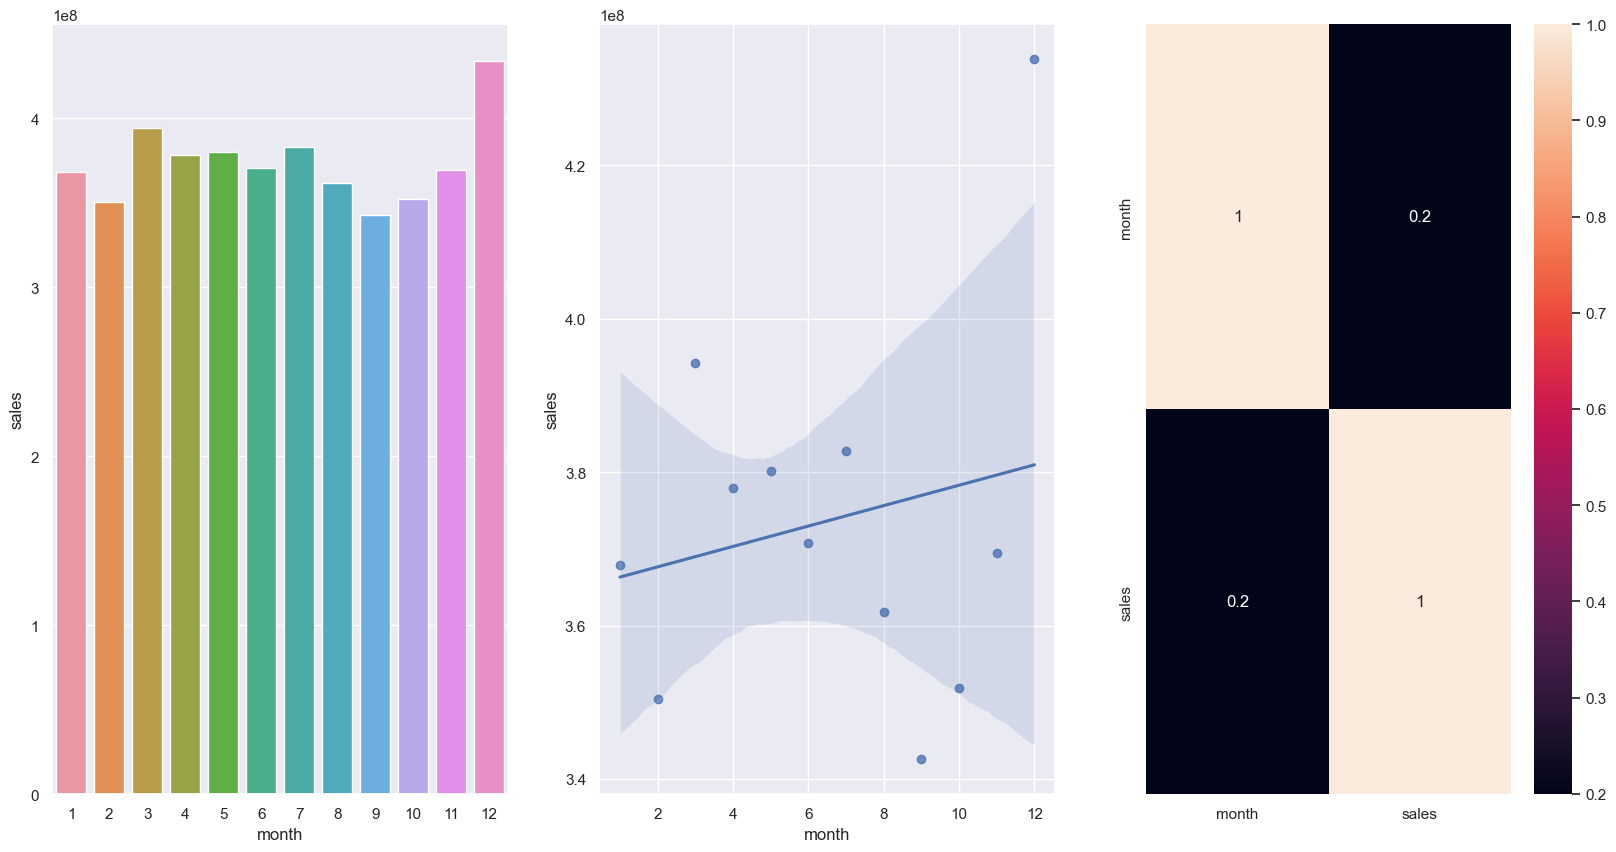

In [40]:
aux1 = df4[df4['year'] < 2015][['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.10. H10. Stores should sell more after the 10th of each month.

True: Stores really sell more after the 10th day of each month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

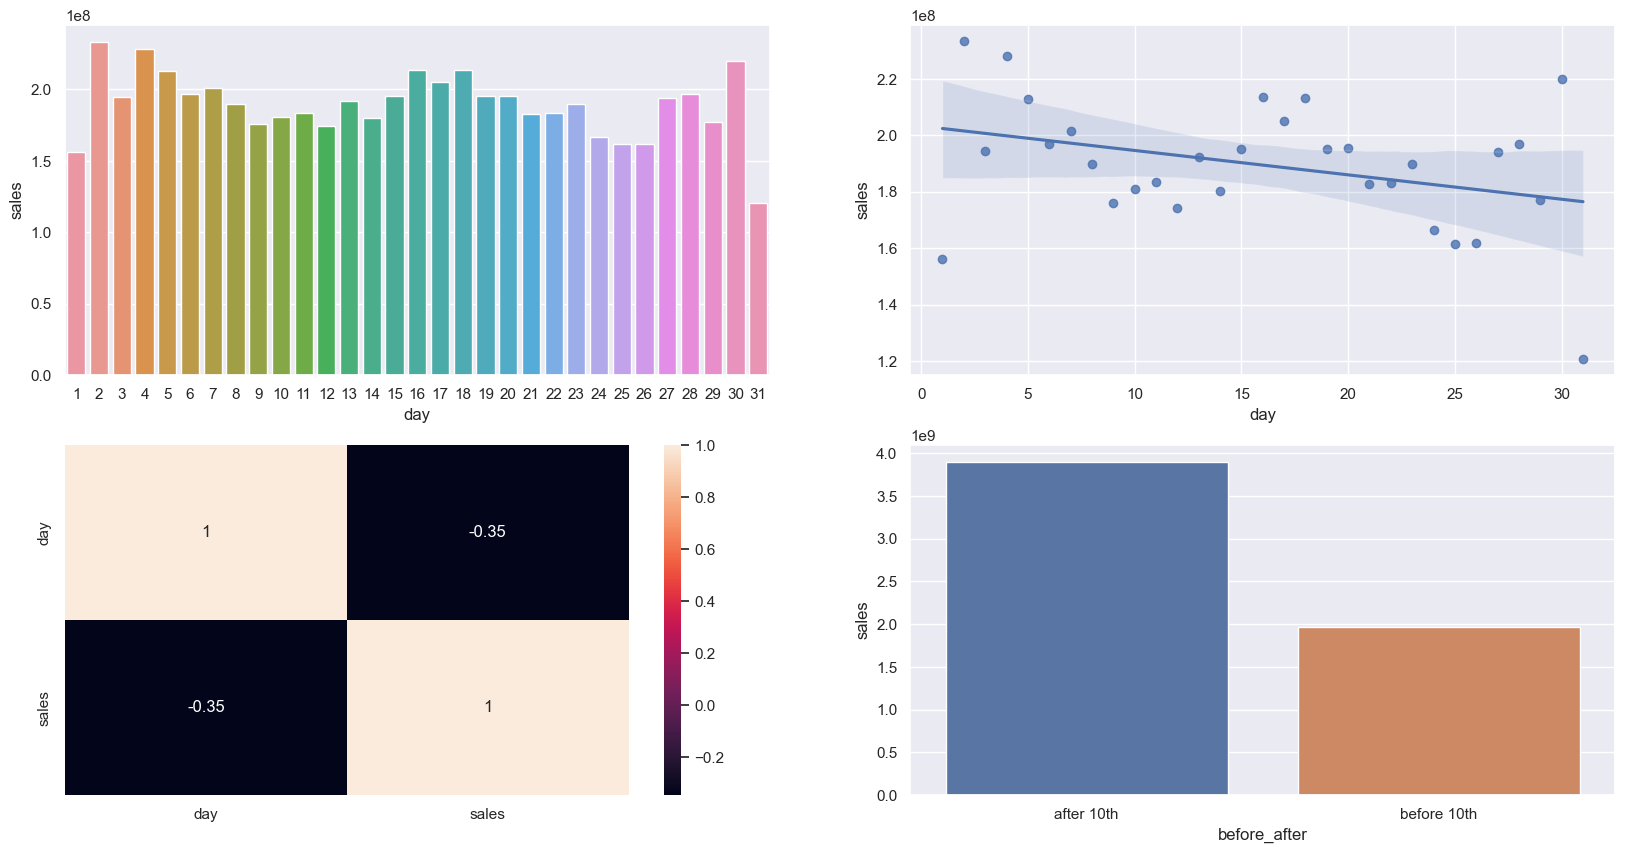

In [41]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before 10th' if x <= 10 else 'after 10th')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)

### 4.2.11. H11. Stores should sell less on weekends.

True: Saturday and Sun are the worst seling days.

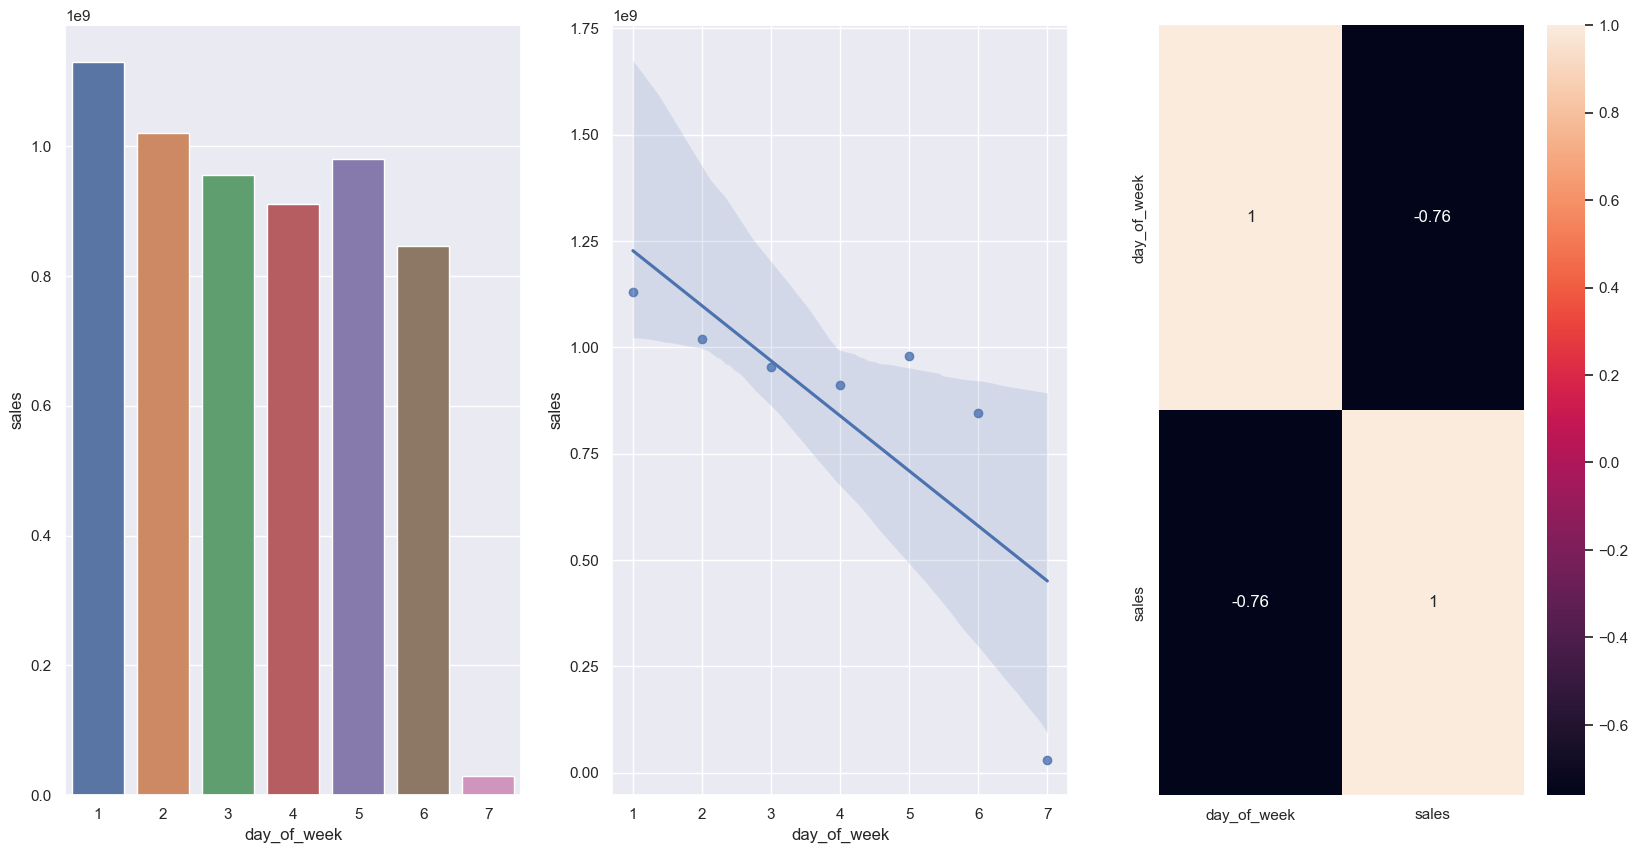

In [42]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.12. H12. Stores should sell less during school holidays.

True: Stores sellless during school holiday except for the august.

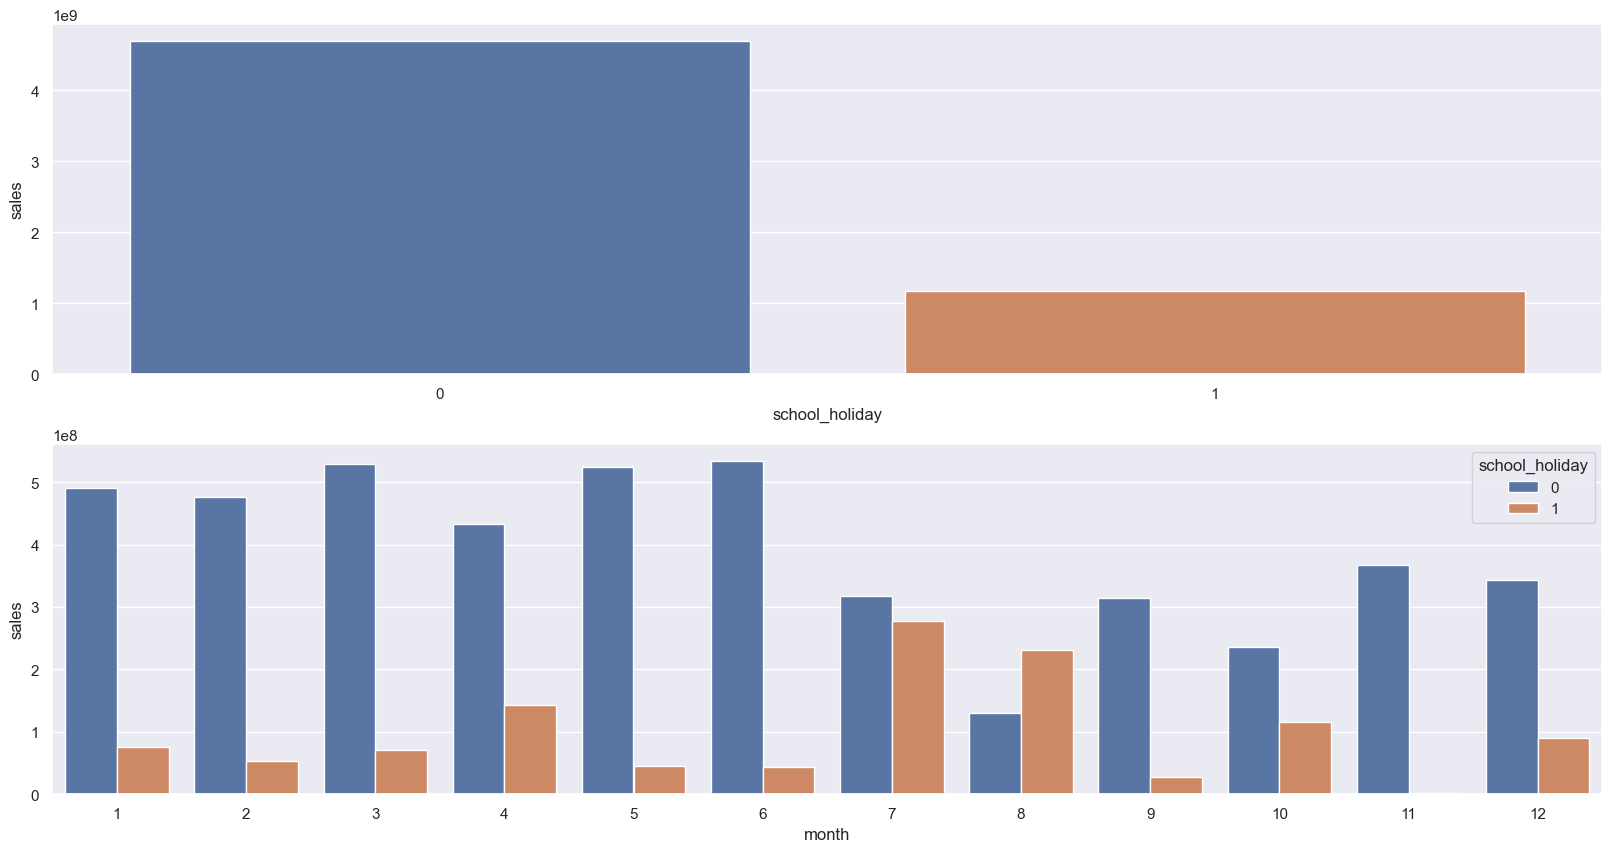

In [43]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.13. Summary of Hypothesis

In [44]:
tab =[['Hyothesis', 'Conclusion', 'Relevance'],
      ['H1',        'True',       'Baixa'],
      ['H2',        'False',      'Media'],
      ['H3',        'False',      'Media'],
      ['H4',        'False',      'Baixa'],
      ['H5',        '-',          '-'],
      ['H6',        'False',      'Baixa'],
      ['H7',        'False',      'Media'],
      ['H8',        'False',      'Alta'],
      ['H9',        'True',       'Alta'],
      ['H10',       'True',       'Alta'],
      ['H11',       'True',       'Alta'],
      ['H12',       'True',       'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )

Hyothesis    Conclusion    Relevance
-----------  ------------  -----------
H1           True          Baixa
H2           False         Media
H3           False         Media
H4           False         Baixa
H5           -             -
H6           False         Baixa
H7           False         Media
H8           False         Alta
H9           True          Alta
H10          True          Alta
H11          True          Alta
H12          True          Baixa


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

<AxesSubplot:>

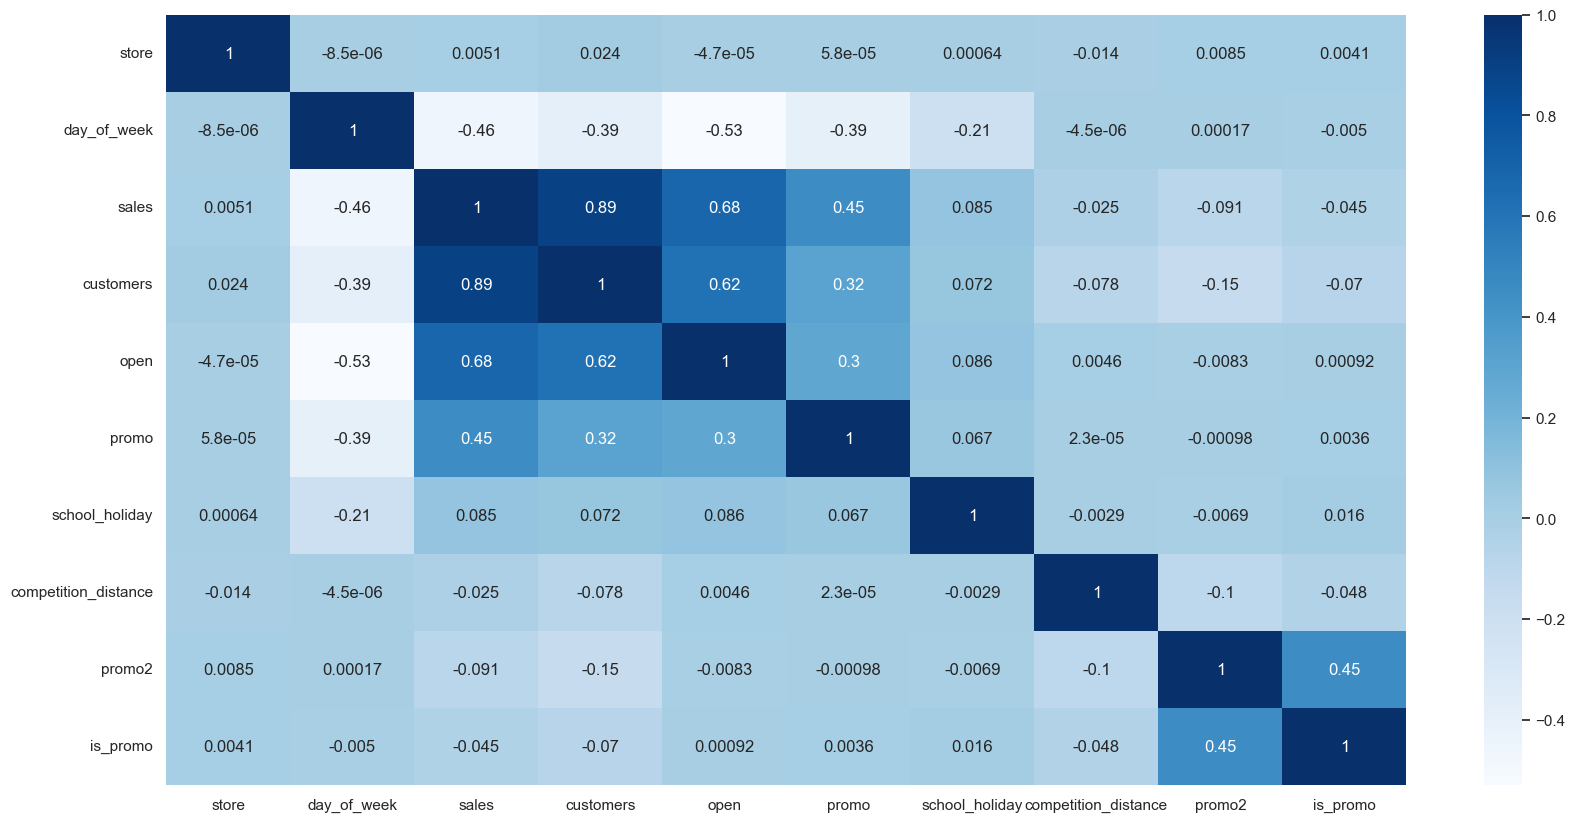

In [45]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, cmap="Blues", annot=True)

### 4.3.2. Categorical Variables

<AxesSubplot:>

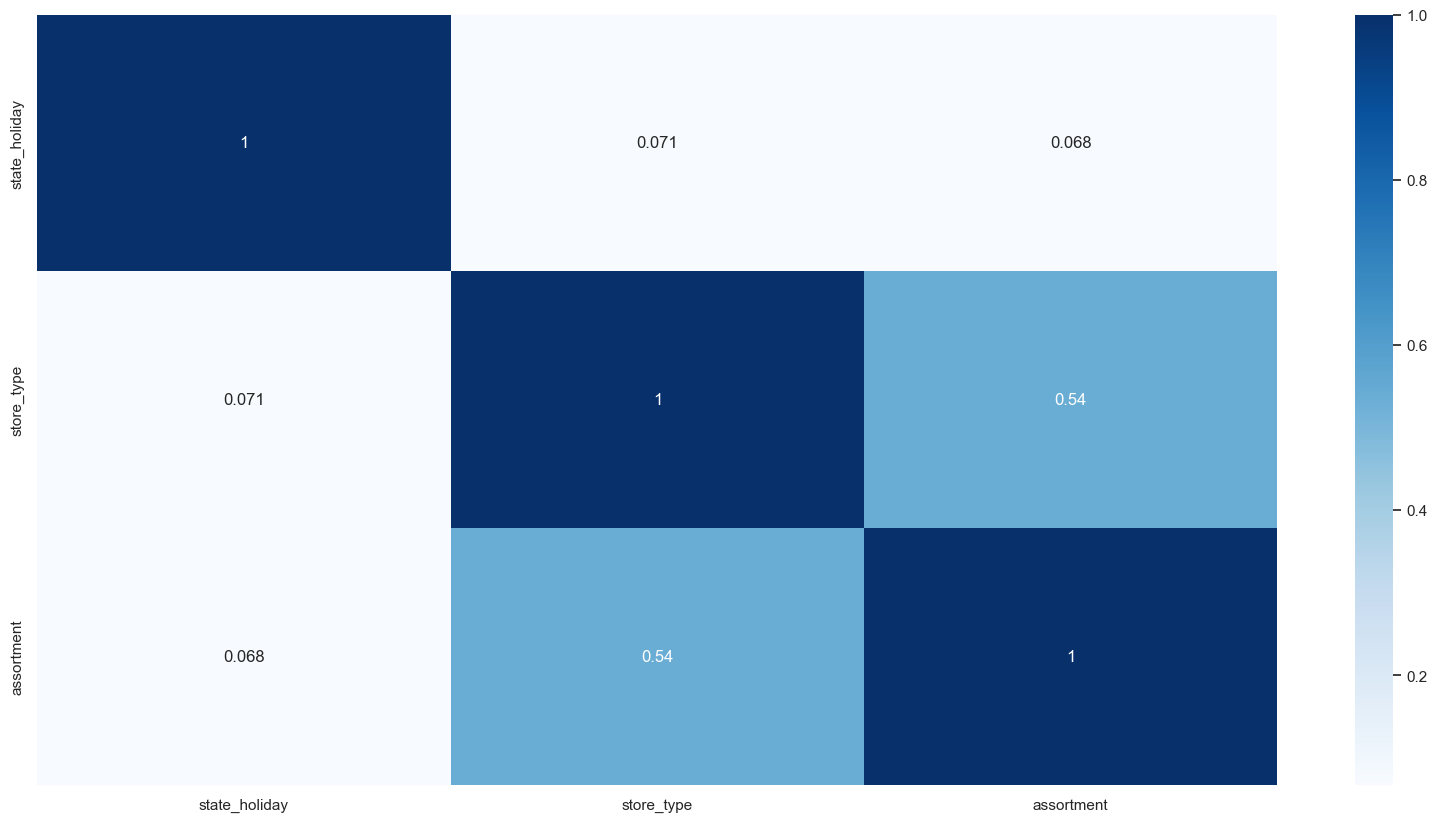

In [46]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type':    [a4, a5, a6],
                  'assortment':    [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, cmap="Blues", annot=True)

# 5. Data Preparation

In [47]:
df5 = df4.copy()

## 5.1. Normalization

No variables with normal distribution to be normalized.

## 5.2. Rescaling

In [48]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

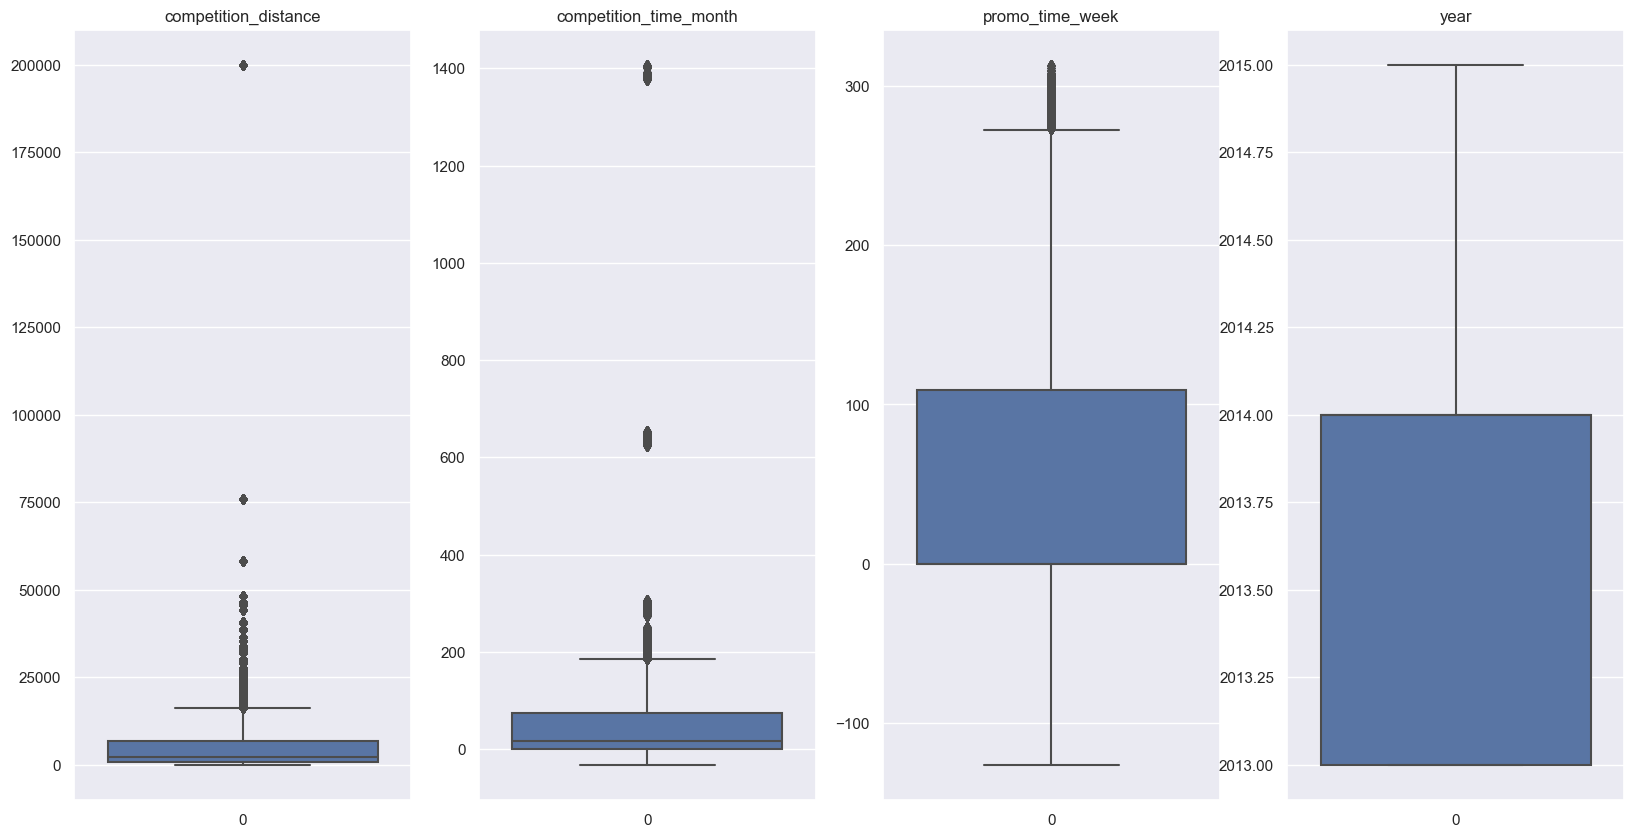

In [49]:
plt.subplot(1, 4, 1)
sns.boxplot(df5['competition_distance']).set(title='competition_distance');

plt.subplot(1, 4, 2)
sns.boxplot(df5['competition_time_month']).set(title='competition_time_month');

plt.subplot(1, 4, 3)
sns.boxplot(df5['promo_time_week']).set(title='promo_time_week');

plt.subplot(1, 4, 4)
sns.boxplot(df5['year']).set(title='year');

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [51]:
# 'state_holiday' - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# 'store_type' - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# 'assortment' - Ordinal ENcoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [52]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [53]:
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

# 6. Feature Selection

In [54]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [56]:
# ssing the last 6 weeks to test the model because the objective of this model is to predict the sales of the last 6 weeks
df6[['store', 'date']].groupby('store').min().reset_index()['date'][0] - timedelta(days=6 * 7)

Timestamp('2012-11-21 00:00:00')

In [57]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# training dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Train Min Date: {}'.format(X_train['date'].min()))
print('Train Max Date: {}'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [71]:
# train and test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define random forest
rf = RandomForestRegressor(n_jobs=-1)

# define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features

In [72]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected features
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [73]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [74]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [58]:
# columns selected by boruta
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add to the ones boruta selected
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7. Machine Learning Modeling

In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


## 7.2. Linear Regression Model

In [63]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict (x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### 7.2.1. Cross Validation

In [64]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [65]:
# model
lrr = Lasso().fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict (x_test)

# performance
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,2198.58,0.34,3110.51


### 7.3.1 Cross Validation

In [66]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


## 7.4. Random Forest Regressor

In [60]:
# model
rf = RandomForestRegressor(n_jobs=-1).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict (x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.89,0.10,1011.11


### 7.4.1 Cross Validation

In [61]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.19 +/- 219.44,0.12 +/- 0.02,1257.2 +/- 319.72


## 7.5. XGBoost Regressor

In [59]:
# model -  can use tree_method ='gpu_hist' to run on gpu
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict (x_test)

# pemodel_xgbormance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.96,0.13,1238.55


### 7.5.1. Cross Validation

In [60]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


## 7.6. Compare Models Performance

### 7.6.1. Single Performance

In [69]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.89,0.10,1011.11
0,XGBoost Regressor,868.96,0.13,1238.55
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Lasso,2198.58,0.34,3110.51


### 7.6.2. Real Performance

In [70]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55
0,Random Forest Regressor,838.19 +/- 219.44,0.12 +/- 0.02,1257.2 +/- 319.72
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


# 8. Hyperparameter Fine Tuning

## 8.1. Random Search

In [60]:
param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
         'eta':[0.01, 0.03],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]}

MAX_EVAL = 10

In [61]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
    print("iteration {}: {}".format(i + 1, hp))

    # model -  can use tree_method ='gpu_hist' to run on gpu
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 subsample=hp['subsample'],
                                 min_child_weight=hp['min_child_weight'])

    # pemodel_xgbormance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

iteration 1: {'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
iteration 2: {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
iteration 3: {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
iteration 4: {'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
iteration 5: {'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
iteration 6: {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
iteration 7: {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
iteration 8: {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,859.39 +/- 137.04,0.12 +/- 0.01,1236.95 +/- 193.05
0,XGBoost Regressor,1332.92 +/- 143.2,0.18 +/- 0.01,1918.29 +/- 177.96
0,XGBoost Regressor,799.19 +/- 129.87,0.11 +/- 0.01,1161.45 +/- 198.23
0,XGBoost Regressor,954.86 +/- 136.36,0.13 +/- 0.01,1381.28 +/- 196.9
0,XGBoost Regressor,815.42 +/- 135.83,0.12 +/- 0.01,1175.97 +/- 197.93
0,XGBoost Regressor,1428.24 +/- 145.84,0.2 +/- 0.01,2063.07 +/- 187.17
0,XGBoost Regressor,936.98 +/- 129.34,0.13 +/- 0.01,1339.09 +/- 175.61
0,XGBoost Regressor,1083.96 +/- 132.09,0.15 +/- 0.01,1562.36 +/- 177.07
0,XGBoost Regressor,1204.55 +/- 124.78,0.17 +/- 0.01,1736.98 +/- 161.85
0,XGBoost Regressor,1764.01 +/- 184.27,0.25 +/- 0.01,2530.02 +/- 249.15


## 8.2. Final Model

In [63]:
# iteration 3: {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
param_tuned = {'n_estimators': 2500,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.7,
               'colsample_bytree': 0.7,
               'min_child_weight': 8}


In [64]:
# model -  can use tree_method ='gpu_hist' to run on gpu
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   subsample=param_tuned['subsample'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# pemodel_xgbormance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,620.55,0.09,907.26


In [70]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.003867282519586427

In [65]:
pickle.dump(model_xgb_tuned, open('model_rossmann.pkl', 'wb'))

# 9. Error Interpretation

In [74]:
df9 = X_test[cols_selected_boruta_full].copy()

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Bisuness Performance

In [75]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [86]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105996.45,102678.89,109314.00,3317.56,0.56
908,909,238830.75,231211.06,246450.44,7619.69,0.52
875,876,200932.16,196990.77,204873.54,3941.39,0.29
721,722,350512.69,348587.91,352437.46,1924.78,0.26
594,595,399258.06,395745.77,402770.36,3512.30,0.24


<AxesSubplot:xlabel='store', ylabel='MAPE'>

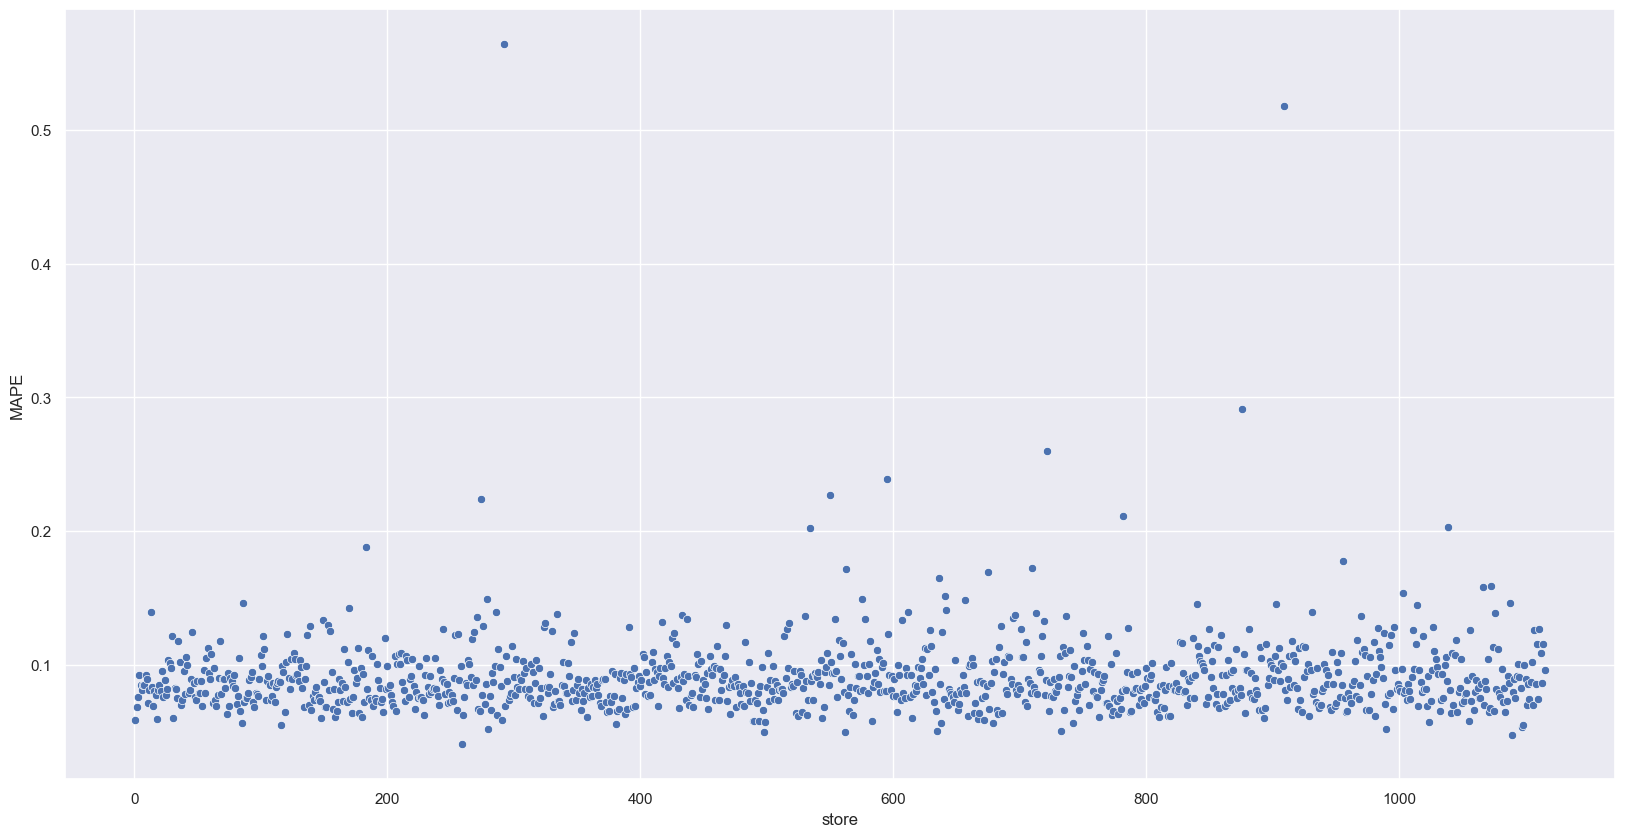

In [87]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [91]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('RS {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"RS 283,872,384.00"
1,worst_scenario,"RS 283,176,263.72"
2,best_scenario,"RS 284,568,535.67"


## 9.3. Machine Learning Performance

In [99]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\pma2022\AppData\Local\Temp\ipykernel_900\1339616108.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error']);


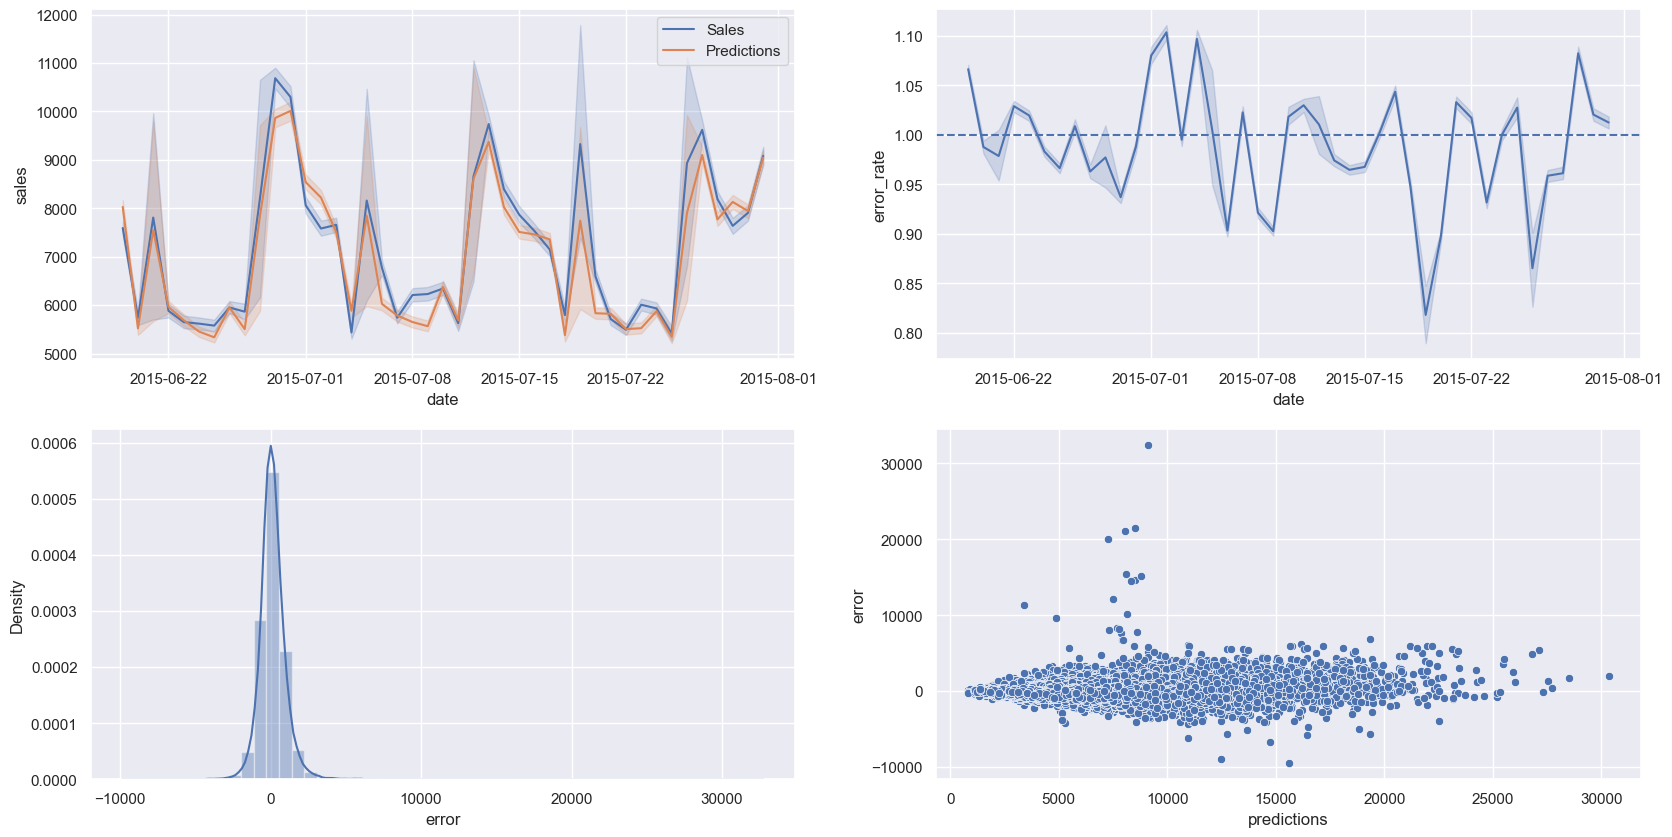

In [100]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales');
sns.lineplot(x='date', y='predictions', data=df9, label='Predictions');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3)
sns.distplot(df9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error']);
